#**Mudanças e Melhorias a serem feitas**#
* Identificar e corrigir o problema do timestemp


##Bibliotecas Utilizadas

In [1]:
!pip install pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import matplotlib.pyplot as plt
from datetime import datetime
import matplotlib as mcolors
import seaborn as sns
import pandas as pd
import numpy as np

%matplotlib inline

In [3]:
##Utilizei dados 50 para modelo e dados 43 para validação.
dados_controle =  'https://raw.githubusercontent.com/Moises788/LAMP-IC-UFRN/main/Rodada50/dados.csv'
dados_rede = 'https://raw.githubusercontent.com/Moises788/LAMP-IC-UFRN/main/Rodada50/pwlogger.csv'

## Pré processamento das variáveis

In [4]:
#Leitura e conversão de tempo do dataframe de controle
data = pd.read_csv(dados_controle)
#data['Date'] = "2022-08-16 " + data['Date'] 
data['Date'] = pd.to_datetime(data['Date'])

#Leitura e conversão de t empo do dataframe de rede
rede = pd.read_csv(dados_rede)
rede['Date'] = pd.to_datetime(rede['Date'])


In [5]:
data

,LV1,SPVolt,Output,Date,ST_Lv1
0,0.00,0.0,0,2023-01-13 08:32:46,0
1,99.86,100.0,573,2023-01-13 08:32:47,128
2,99.86,100.0,573,2023-01-13 08:32:48,128
3,100.22,100.0,573,2023-01-13 08:32:49,128
4,100.22,100.0,576,2023-01-13 08:32:50,128
...,...,...,...,...,...
7631,100.12,100.0,580,2023-01-13 10:39:57,128
7632,99.99,100.0,580,2023-01-13 10:39:58,128
7633,99.79,100.0,580,2023-01-13 10:39:59,128
7634,99.61,100.0,576,2023-01-13 10:40:00,128


In [6]:
st_lv1 = data['ST_Lv1']

In [7]:
print(rede.shape)
print(data.shape)

(15272, 11)
(7636, 5)


In [8]:
device01 = rede
device05 = rede

indexNames01 = device01[ device01['Devices'] == 'TT-IS-05' ].index #pega as linhas do sensor 05
indexNames05 = device05[ device05['Devices'] == 'LD-IS-01' ].index #pega as linhas do sensor 01

In [9]:
print(indexNames01.shape)
print(indexNames05.shape)

(7636,)
(7636,)


In [10]:
device01 = device01.drop(indexNames01) #Exclui os sensores 05
device05 = device05.drop(indexNames05) #Exclui os sensore 01

In [11]:
print(device01.shape)
print(device05.shape)

(7636, 11)
(7636, 11)


In [12]:
device01 = device01.drop(columns = ['Neighbors', 'Clock Source' , 'Link Status','DPDU Rx',	'DPDU Rx Fail'])
device05 = device05.drop(columns = ['Neighbors', 'Clock Source' , 'Link Status','DPDU Rx',	'DPDU Rx Fail'])

In [13]:
print(device01.shape)
print(device05.shape)

(7636, 6)
(7636, 6)


##Calculo de PDR

In [14]:
device05 = device05.reset_index(drop=True)
device01 = device01.reset_index(drop=True)
device05

,Date,Devices,DPDU Tx,DPDU Tx Fail,RSSI,Quality
0,2023-01-13 08:32:43,TT-IS-05,6550,150,-53,Excellent Signal(196)
1,2023-01-13 08:32:44,TT-IS-05,6550,150,-53,Excellent Signal(196)
2,2023-01-13 08:32:45,TT-IS-05,6550,150,-53,Excellent Signal(196)
3,2023-01-13 08:32:46,TT-IS-05,6550,150,-53,Excellent Signal(196)
4,2023-01-13 08:32:47,TT-IS-05,6550,150,-53,Excellent Signal(196)
...,...,...,...,...,...,...
7631,2023-01-13 10:39:54,TT-IS-05,19995,1362,-80,Poor Signal(57)
7632,2023-01-13 10:39:55,TT-IS-05,19995,1362,-80,Poor Signal(57)
7633,2023-01-13 10:39:56,TT-IS-05,19995,1362,-80,Poor Signal(57)
7634,2023-01-13 10:39:57,TT-IS-05,19995,1362,-80,Poor Signal(57)


In [15]:
pacotes01 =pd.DataFrame({"pacotes enviados 01":device01['DPDU Tx'],
                   "pacotes perdidos 01":device01['DPDU Tx Fail']})

pacotes05 = pd.DataFrame({ "pacotes enviados 05":device05['DPDU Tx'],
                   "pacotes perdidos 05":device05['DPDU Tx Fail']})

In [16]:
pacotes01 = pacotes01.reset_index(drop=True)
pacotes05 = pacotes05.reset_index(drop=True)


In [17]:
pacotes05

,pacotes enviados 05,pacotes perdidos 05
0,6550,150
1,6550,150
2,6550,150
3,6550,150
4,6550,150
...,...,...
7631,19995,1362
7632,19995,1362
7633,19995,1362
7634,19995,1362


In [18]:
#Expressão para realizar calculo de perda de pacote
delta_df = pd.DataFrame()
perdaPacote = pd.DataFrame()
for indicie, linha in pacotes05.iterrows():
      if (indicie == 0):
            delta_df = pacotes05.iloc[indicie]           
      elif (indicie >= 1) and (indicie <= len(pacotes05.index) and (pacotes05["pacotes enviados 05"].iloc[indicie] != pacotes05["pacotes enviados 05"].iloc[indicie-1])):
            delta_df = pacotes05.iloc[indicie] - pacotes05.iloc[indicie-1]             
      perdaPacote = perdaPacote.append(delta_df, ignore_index= True)


DPDU_Tx_Fail05 = perdaPacote["pacotes perdidos 05"]
DPDU_Tx05 = perdaPacote["pacotes enviados 05"]  

In [19]:
#Expressão para realizar calculo de perda de pacote
delta_df = pd.DataFrame()
perdaPacote = pd.DataFrame()
for indicie, linha in pacotes01.iterrows():
      if (indicie == 0):
            delta_df = pacotes01.iloc[indicie]           
      elif (indicie >= 1) and (indicie <= len(pacotes01.index) and (pacotes01["pacotes enviados 01"].iloc[indicie] != pacotes01["pacotes enviados 01"].iloc[indicie-1])):
            delta_df = pacotes01.iloc[indicie] - pacotes01.iloc[indicie-1]             
      perdaPacote = perdaPacote.append(delta_df, ignore_index= True)


DPDU_Tx_Fail01 = perdaPacote["pacotes perdidos 01"]
DPDU_Tx01 = perdaPacote["pacotes enviados 01"]  

In [20]:
link01 = pd.DataFrame({"pacotes enviados 01":DPDU_Tx01,
                   "pacotes perdidos 01":DPDU_Tx_Fail01})

link05 = pd.DataFrame({"pacotes enviados 05":DPDU_Tx05,
                   "pacotes perdidos 05":DPDU_Tx_Fail05})

In [21]:
PDRI05 = (DPDU_Tx05/(DPDU_Tx_Fail05+DPDU_Tx05)) * 100 #Eviado/(Eviado+Perdido)
PDRI01 = (DPDU_Tx01/(DPDU_Tx_Fail01+DPDU_Tx01)) * 100 #Eviado/(Eviado+Perdido)


In [22]:
PDRI01

0       98.337950
1       98.337950
2       98.337950
3       98.337950
4       98.337950
          ...    
7631    56.410256
7632    56.410256
7633    56.410256
7634    56.410256
7635    56.410256
Length: 7636, dtype: float64

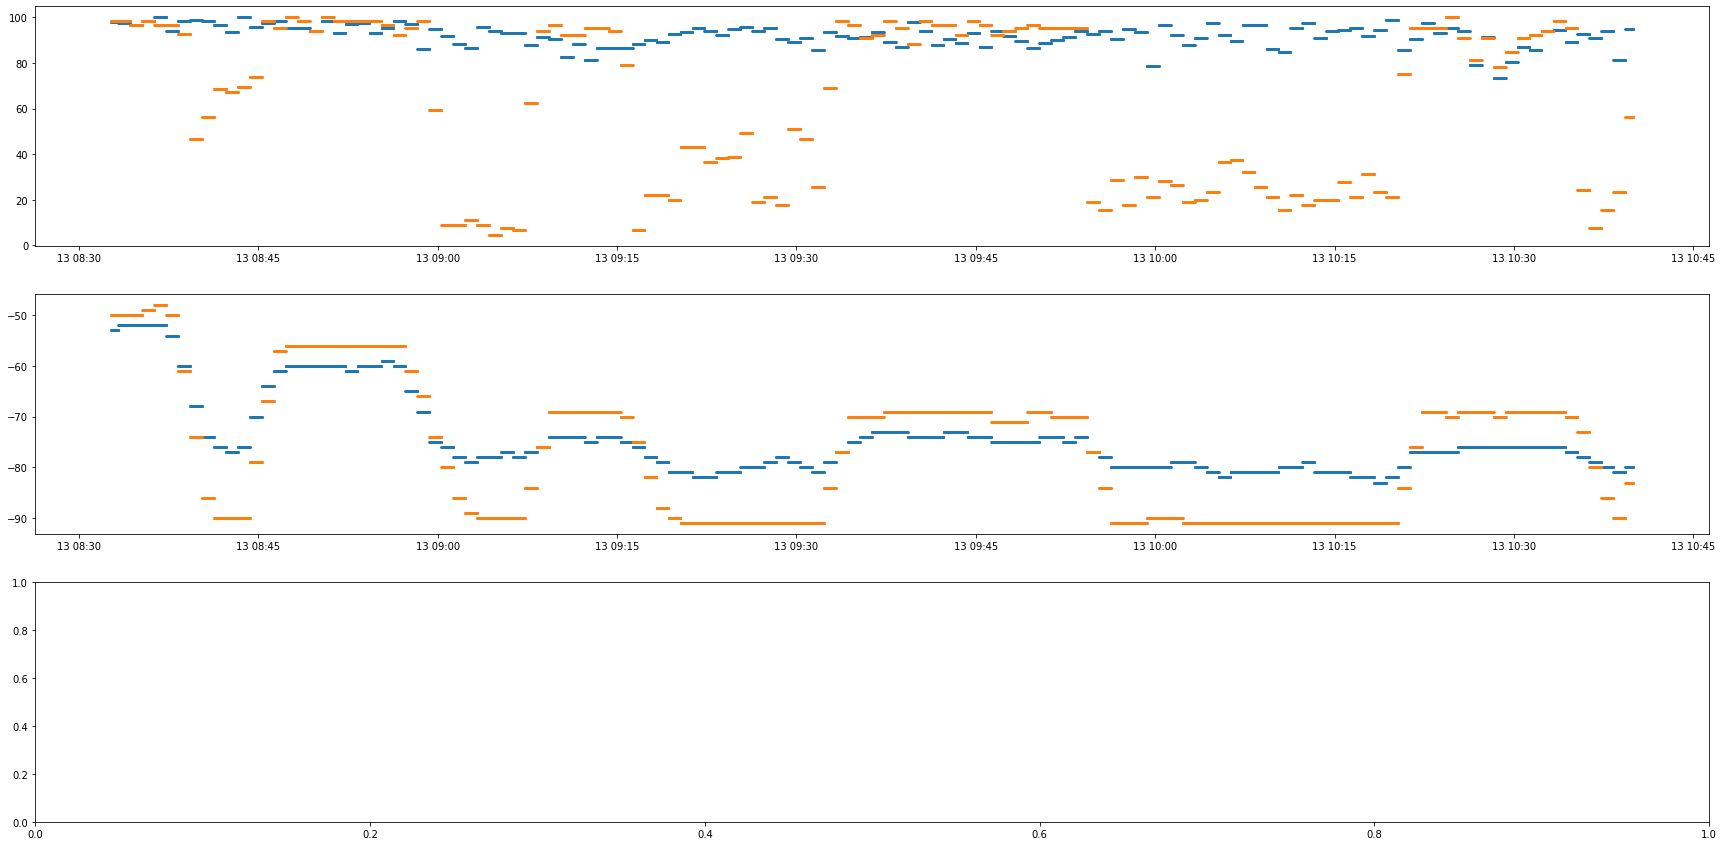

In [23]:
fig, ax= plt.subplots(nrows=3, ncols=1, figsize=(30,15))

ax[0].scatter(device05['Date'], PDRI05, s=3)
ax[0].scatter(device01['Date'], PDRI01, s=3)

ax[1].scatter(device05['Date'], device05['RSSI'], s=3)
ax[1].scatter(device01['Date'], device01['RSSI'], s=3)
#ax[0].set_xticks(time[0:len(time):int((len(time)/5))]) # Usa isto para definires as tuas labels
fig.savefig('pdrBruto.pdf', format='pdf')

In [24]:
device01

,Date,Devices,DPDU Tx,DPDU Tx Fail,RSSI,Quality
0,2023-01-13 08:32:43,LD-IS-01,3195,54,-50,Excellent Signal(208)
1,2023-01-13 08:32:44,LD-IS-01,3195,54,-50,Excellent Signal(208)
2,2023-01-13 08:32:45,LD-IS-01,3195,54,-50,Excellent Signal(208)
3,2023-01-13 08:32:46,LD-IS-01,3195,54,-50,Excellent Signal(208)
4,2023-01-13 08:32:47,LD-IS-01,3195,54,-50,Excellent Signal(208)
...,...,...,...,...,...,...
7631,2023-01-13 10:39:54,LD-IS-01,8704,4222,-83,Poor Signal(44)
7632,2023-01-13 10:39:55,LD-IS-01,8704,4222,-83,Poor Signal(44)
7633,2023-01-13 10:39:56,LD-IS-01,8704,4222,-83,Poor Signal(44)
7634,2023-01-13 10:39:57,LD-IS-01,8704,4222,-83,Poor Signal(44)


##Realiza junção dos sensores em um só dataframe

In [25]:
print(device01.shape)
print(device05.shape)

(7636, 6)
(7636, 6)


In [26]:
device01['DPDU Tx'] = link01['pacotes enviados 01']
device01['DPDU Tx Fail'] = link01['pacotes perdidos 01']

device05['DPDU Tx'] = link05['pacotes enviados 05']
device05['DPDU Tx Fail'] = link05['pacotes perdidos 05']

In [27]:
#device05 =device05.drop('Date', axis=1)
rede = pd.merge(device01, device05, how='left', on='Date')
rede.shape

(7638, 11)

In [28]:
data.index = pd.to_datetime(data['Date'])
rede.index = pd.to_datetime(rede['Date'])

data.drop("Date", inplace=True, axis=1)
rede.drop("Date", inplace=True, axis=1)

df = data.merge(rede, right_index = True,left_index = True, how = 'outer')
df=df.reset_index()

In [29]:
dadosInstantaneos =  df

In [30]:
dadosInstantaneos

,Date,LV1,SPVolt,Output,ST_Lv1,Devices_x,DPDU Tx_x,DPDU Tx Fail_x,RSSI_x,Quality_x,Devices_y,DPDU Tx_y,DPDU Tx Fail_y,RSSI_y,Quality_y
0,2023-01-13 08:32:43,NaN,NaN,NaN,NaN,LD-IS-01,3195.0,54.0,-50.0,Excellent Signal(208),TT-IS-05,6550.0,150.0,-53.0,Excellent Signal(196)
1,2023-01-13 08:32:44,NaN,NaN,NaN,NaN,LD-IS-01,3195.0,54.0,-50.0,Excellent Signal(208),TT-IS-05,6550.0,150.0,-53.0,Excellent Signal(196)
2,2023-01-13 08:32:45,NaN,NaN,NaN,NaN,LD-IS-01,3195.0,54.0,-50.0,Excellent Signal(208),TT-IS-05,6550.0,150.0,-53.0,Excellent Signal(196)
3,2023-01-13 08:32:46,0.00,0.0,0.0,0.0,LD-IS-01,3195.0,54.0,-50.0,Excellent Signal(208),TT-IS-05,6550.0,150.0,-53.0,Excellent Signal(196)
4,2023-01-13 08:32:47,99.86,100.0,573.0,128.0,LD-IS-01,3195.0,54.0,-50.0,Excellent Signal(208),TT-IS-05,6550.0,150.0,-53.0,Excellent Signal(196)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7637,2023-01-13 10:39:57,100.12,100.0,580.0,128.0,LD-IS-01,44.0,34.0,-83.0,Poor Signal(44),TT-IS-05,108.0,6.0,-80.0,Poor Signal(57)
7638,2023-01-13 10:39:58,99.99,100.0,580.0,128.0,LD-IS-01,44.0,34.0,-83.0,Poor Signal(44),TT-IS-05,108.0,6.0,-80.0,Poor Signal(57)
7639,2023-01-13 10:39:59,99.79,100.0,580.0,128.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7640,2023-01-13 10:40:00,99.61,100.0,576.0,128.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
Nivel_tank = df["LV1"]
Saida = df["Output"]
Setpoint = df["SPVolt"]
tempo = df['Date']

#tempo = tempo.astype(str)

tempo_rede = tempo

DPDU_Tx01 = dadosInstantaneos['DPDU Tx_x']
DPDU_Tx_Fail01 = dadosInstantaneos['DPDU Tx Fail_x']
RSSI_rede01 = dadosInstantaneos['RSSI_x']

DPDU_Tx05 = dadosInstantaneos['DPDU Tx_y']
DPDU_Tx_Fail05 = dadosInstantaneos['DPDU Tx Fail_y']
RSSI_rede05 = dadosInstantaneos['RSSI_y']

df2 =pd.DataFrame({"pacotes enviados 01":DPDU_Tx01,
                   "pacotes perdidos 01":DPDU_Tx_Fail01})

df3 = pd.DataFrame({ "pacotes enviados 05":DPDU_Tx05,
                   "pacotes perdidos 05":DPDU_Tx_Fail05})


In [32]:
df.drop(["LV1", "Output", "SPVolt"], inplace=True, axis=1)
tempo = df['Date']
df.drop("Date", inplace=True, axis=1)

In [33]:
rede = pd.read_csv(dados_rede)
rede['Date'] = pd.to_datetime(rede['Date'])
rede = pd.merge(device01, device05, how='left', on='Date')
#rede.drop("Date", inplace=True, axis=1)
rede

,Date,Devices_x,DPDU Tx_x,DPDU Tx Fail_x,RSSI_x,Quality_x,Devices_y,DPDU Tx_y,DPDU Tx Fail_y,RSSI_y,Quality_y
0,2023-01-13 08:32:43,LD-IS-01,3195.0,54.0,-50,Excellent Signal(208),TT-IS-05,6550.0,150.0,-53,Excellent Signal(196)
1,2023-01-13 08:32:44,LD-IS-01,3195.0,54.0,-50,Excellent Signal(208),TT-IS-05,6550.0,150.0,-53,Excellent Signal(196)
2,2023-01-13 08:32:45,LD-IS-01,3195.0,54.0,-50,Excellent Signal(208),TT-IS-05,6550.0,150.0,-53,Excellent Signal(196)
3,2023-01-13 08:32:46,LD-IS-01,3195.0,54.0,-50,Excellent Signal(208),TT-IS-05,6550.0,150.0,-53,Excellent Signal(196)
4,2023-01-13 08:32:47,LD-IS-01,3195.0,54.0,-50,Excellent Signal(208),TT-IS-05,6550.0,150.0,-53,Excellent Signal(196)
...,...,...,...,...,...,...,...,...,...,...,...
7633,2023-01-13 10:39:54,LD-IS-01,44.0,34.0,-83,Poor Signal(44),TT-IS-05,108.0,6.0,-80,Poor Signal(57)
7634,2023-01-13 10:39:55,LD-IS-01,44.0,34.0,-83,Poor Signal(44),TT-IS-05,108.0,6.0,-80,Poor Signal(57)
7635,2023-01-13 10:39:56,LD-IS-01,44.0,34.0,-83,Poor Signal(44),TT-IS-05,108.0,6.0,-80,Poor Signal(57)
7636,2023-01-13 10:39:57,LD-IS-01,44.0,34.0,-83,Poor Signal(44),TT-IS-05,108.0,6.0,-80,Poor Signal(57)


##Ponto Crítico

In [34]:
#executa a distribuição dos dados de pacotes enviados e recebidos
rodada = 0
indicie_rede = 0
completo = pd.DataFrame()
lista = []
for indicie, linha in df.iterrows():
    if df.loc[indicie].isnull().values.any() == True:
      #indicie_rede += 1  
      if rodada == 0:  
        indicie_rede = 0
      lista.append(indicie_rede)
    else:
      if rodada == 0:
        indicie_rede = 0
        rodada = 1
      else:
        indicie_rede += 1
    completo = completo.append(rede.loc[indicie_rede], ignore_index= True) 

In [35]:
data = pd.read_csv(dados_controle)
data['Date'] = pd.to_datetime(data['Date'])
df = data.merge(completo, left_index=True, right_index=True, how = 'outer')
#df.to_csv('DadosCompletos.csv')
df = df.dropna()
df['Date'] = tempo


##Separação de variáveis

In [36]:

tempo = df["Date"]
Nivel_tank = df["LV1"]
Saida = df["Output"]
Setpoint = df["SPVolt"]

#tempo = tempo.astype(str)

tempo_rede = tempo

DPDU_Tx01 = df['DPDU Tx_x']
DPDU_Tx_Fail01 = df['DPDU Tx Fail_x']
RSSI_rede01 = df['RSSI_x']

DPDU_Tx05 = df['DPDU Tx_y']
DPDU_Tx_Fail05 = df['DPDU Tx Fail_y']
RSSI_rede05 = df['RSSI_y']




In [37]:
df2 =pd.DataFrame({"pacotes enviados 01":DPDU_Tx01,
                   "pacotes perdidos 01":DPDU_Tx_Fail01})

df3 = pd.DataFrame({ "pacotes enviados 05":DPDU_Tx05,
                   "pacotes perdidos 05":DPDU_Tx_Fail05})

##Código abaixo responsável por realizar o cálculo de perda real de pacote

In [38]:
erro = (abs(Nivel_tank-Setpoint)/Setpoint)*100
DPDU_Total01 = DPDU_Tx01 + DPDU_Tx_Fail01
DPDU_Total05 = DPDU_Tx05 + DPDU_Tx_Fail05
PDRI01 = (DPDU_Tx01/DPDU_Total01) * 100
PDRI05 = (DPDU_Tx05/DPDU_Total05) * 100
Saida = Saida*(3.3/1024)


## Plot dos gráficos

In [39]:
from datetime import time

time = pd.to_datetime(tempo, format = '%H:%M:%S')
time = time.dt.strftime('%H:%M:%S')
time =  time.values.tolist()

for i in range(len(time)):
  hora = time[i][0:2]
  minuto = time[i][3:5]
  segundo = time[i][6:8]
  #time(hour=hora , minute=minuto, second=segundo)
  #print(time)

In [40]:
#fig, ax= plt.subplots(nrows=3, ncols=1, figsize=(30,15))


#ax[0].scatter(time, PDRI01, label = 'link 1', color = '#0000FF', s= 0.7)
#ax[0].scatter(time, PDRI05, label = 'link 2', color = '#008000', s= 0.7)

##ax[0].set_xticks(time[0:len(time):int((len(time)/10))])


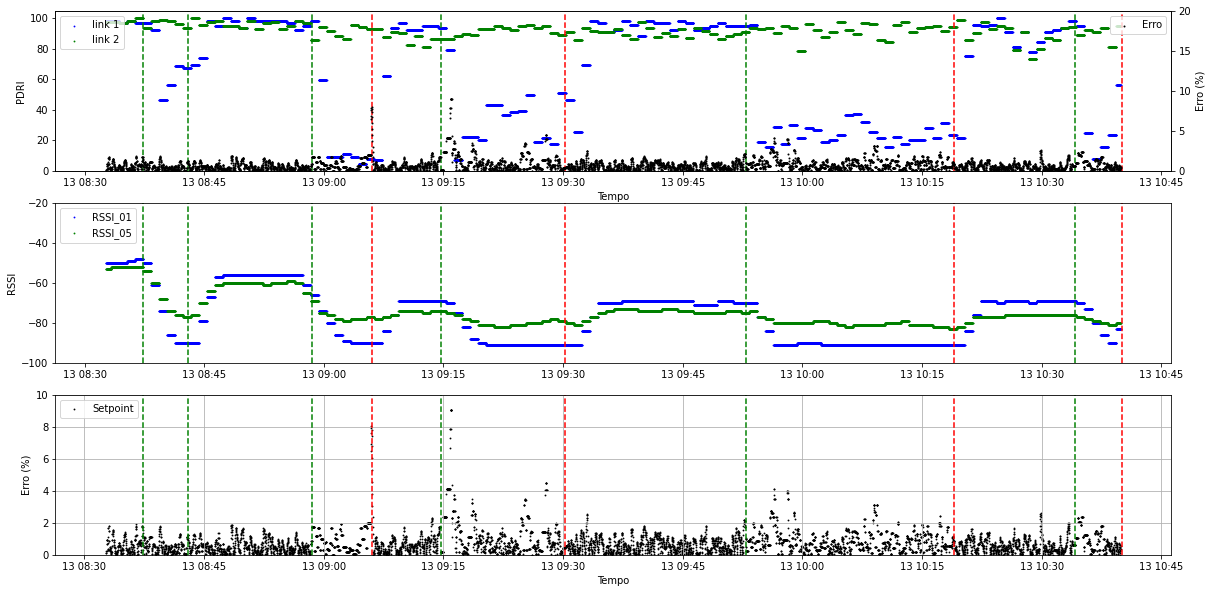

In [51]:
fig, ax= plt.subplots(nrows=3, ncols=1, figsize=(20,10))


ax[0].scatter(tempo_rede, PDRI01, label = 'link 1', color = '#0000FF', s= 0.7)
ax[0].scatter(tempo_rede, PDRI05, label = 'link 2', color = '#008000', s= 0.7)

ax[0].set_xlabel('Tempo')
ax[0].set_ylabel('PDRI')
ax[0].legend(['link 1', 'link 2', 'Erro'], loc='upper left')

aux = ax[0].twinx() #método para criar dois eixos y
aux.scatter(tempo, erro, label = 'Erro', color = 'black', s= 1)
aux.legend()
aux.set_ylabel('Erro (%)')
aux.set_ylim(0, 20)

#ax[0].legend(handles=[line1], loc='upper right')

ax[1].scatter(tempo_rede, RSSI_rede01, label = 'RSSI_01', s= 0.7, color = '#0000FF')
ax[1].scatter(tempo_rede, RSSI_rede05, label = 'RSSI_05', s= 0.7, color = '#008000')
ax[1].set_ylim(ymin = -100, ymax= -20)
ax[1].set_ylabel('RSSI')
ax[1].legend() #legenda do gráfico

ax[2].scatter(tempo, erro, label = 'Setpoint', color = 'black', s= 0.7)

ax[2].legend() #legenda do gráfico
ax[2].set_xlabel('Tempo')
ax[2].set_ylabel('Erro (%)')
ax[2].set_ylim(ymin = 0, ymax= 10)
ax[2].grid(True)
#(13h36, 13h45; 13h53, 13h 57, 14h03; 14h16, 14h20, 14h29; 14h40, 14h43, 14h49 )



for i in range(3): 

  ax[i].axvline(pd.Timestamp("2023-01-13 08:37:19"),ls='--', color = 'g')
  ax[i].axvline(pd.Timestamp("2023-01-13 08:43:00"),ls='--', color = 'g')

  ax[i].axvline(pd.Timestamp("2023-01-13 08:58:31"),ls='--', color = 'g')
  ax[i].axvline(pd.Timestamp("2023-01-13 09:06:02"),ls='--', color = 'r')
   
  ax[i].axvline(pd.Timestamp("2023-01-13 09:14:44"),ls='--', color = 'g')
  ax[i].axvline(pd.Timestamp("2023-01-13 09:30:17"),ls='--', color = 'r')
  
  ax[i].axvline(pd.Timestamp("2023-01-13 09:52:57"),ls='--', color = 'g')
  ax[i].axvline(pd.Timestamp("2023-01-13 10:19:00"),ls='--', color = 'r')

  ax[i].axvline(pd.Timestamp("2023-01-13 10:34:08"),ls='--', color = 'g')
  ax[i].axvline(pd.Timestamp("2023-01-13 10:40:01"),ls='--', color = 'r')




plt.legend()
figrede = plt.gcf() 
plt.show()

##Salvando dataframe

In [42]:
df_final = pd.DataFrame({ "data":tempo,
                          "RSSI_0":RSSI_rede01,
                          "RSSI_1":RSSI_rede05,
                          "PDRI_0":PDRI01,
                          "PDRI_1":PDRI05,
                          "erro":erro,
                         "st_lv1": st_lv1
                        })
df_final.isnull().sum()

data      0
RSSI_0    0
RSSI_1    0
PDRI_0    0
PDRI_1    0
erro      1
st_lv1    0
dtype: int64

In [43]:
df_final

,data,RSSI_0,RSSI_1,PDRI_0,PDRI_1,erro,st_lv1
0,2023-01-13 08:32:43,-50.0,-53.0,98.337950,97.761194,NaN,0
1,2023-01-13 08:32:44,-50.0,-53.0,98.337950,97.761194,0.14,128
2,2023-01-13 08:32:45,-50.0,-53.0,98.337950,97.761194,0.14,128
3,2023-01-13 08:32:46,-50.0,-53.0,98.337950,97.761194,0.22,128
4,2023-01-13 08:32:47,-50.0,-53.0,98.337950,97.761194,0.22,128
...,...,...,...,...,...,...,...
7631,2023-01-13 10:39:51,-83.0,-80.0,56.410256,94.736842,0.12,128
7632,2023-01-13 10:39:52,-83.0,-80.0,56.410256,94.736842,0.01,128
7633,2023-01-13 10:39:53,-83.0,-80.0,56.410256,94.736842,0.21,128
7634,2023-01-13 10:39:54,-83.0,-80.0,56.410256,94.736842,0.39,128


In [44]:
df_final.dropna(inplace=True)

In [45]:
# Using plotly.express
import plotly.express as px


fig = px.scatter(df_final, x='data', y='erro')
fig.show()

In [48]:
figrede.savefig('plot_dados.pdf', format='pdf')
df_final.to_csv('Dados_para_modelo.csv')